In [2]:
from neuralmonkey.classes.session import load_mult_session_helper
from pythonlib.tools.stroketools import strokesInterpolate2
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
import random
import math
import os

In [187]:
%load_ext autoreload
%autoreload 2


In [204]:
################################################
### Plot a single trial's stimulus/behavior ###
################################################

# plot the task image for a trial
def plotTrialTaskImage(sn, trial, ax=None):
    if ax==None:
        fig, ax = plt.subplots()
    sn.plot_taskimage(ax, trial)
    return ax

# plot the (x,y) data of all drawn strokes
def plotTrialDrawnStrokes(sn, trial, ax=None):
    # get list of strokes and times
    strk = sn.strokes_extract(trial, peanuts_only=True) # NOTE: peanuts_only=True pulls out only drawing strokes (e.g. not fixation etc)
        
    print(strk)
    
    # if no specified ax, then default to overlaying onto task image
    if ax==None:
        ax = plotTrialTaskImage(sn, trial)
        
    # now overlay each stroke
    for s in strk:
        ax.scatter(s[:,0], s[:,1], c='cyan', marker=',', alpha=0.15)
        
    return ax

################################################
### Extracting a Session's successful Trialcodes/Trialnums ###
################################################

# get a list of successful trialcodes
def getSuccessfulTrialCodes(sn):
    D = sn.Datasetbeh
    Dcopy = D.copy()
    Dcopy.preprocessGood(params=["one_to_one_beh_task_strokes"]) # prunes Dcopy to keep only successful trials
    
    return Dcopy.Dat['trialcode'].tolist()

# from the list of trialcodes, get matching list of NEURAL trials
def getNeuralTrialNumsFromTrialCodes(sn, trialcode_list):
    D = sn.Datasetbeh
    trials = []
    for tc in trialcode_list:
        # make sure there is exactly one matching trialcode
        #index_dataset = D.Dat[(D.Dat["trialcode"]==tc)].index
        #assert len(index_dataset)==1

        # pull out these datapoints from trial-level dataset
        t = sn.datasetbeh_trialcode_to_trial(tc)
        trials.append(t)
        #ons, offs = sn.strokes_extract_ons_offs(trialtdt)
    return trials

# get a list of successful trialnums
def getSuccessfulNeuralTrialNums(sn):
    trialcodes = getSuccessfulTrialCodes(sn)
    return getTrialNumsFromTrialCodes(sn, trialcodes)


################################################
### Extracting/Plotting Eye-Tracking Data ###
################################################

# plot raw eye-tracking data (not calibrated, so may be much smaller than task image)
def plotRawEyeXY(sn, trial):
    # get RAW x-coordinates (not transformed by calibration matrix)
    times_x, vals_x, fs_x = sn.extract_data_tank_streams("eyex", trial, ploton=False)

    # get RAW y-coordinates (not transformed by calibration matrix)
    times_y, vals_y, fs_y = sn.extract_data_tank_streams("eyey", trial, ploton=False)

    # plot RAW xy-coordinates
    fig, ax = plt.subplots()
    ax.scatter(vals_x, vals_y)

# plot calibrated/smoothed eye-tracking data over task image
def plotSmCalibEyeXYOverTaskImage(sn, trial):
    x, y, times = getEyeXYSmoothedAndTransformed(sn, trial, PLOT=False)

    # plot RAW xy-coordinates
    fig, ax = plt.subplots()
    plotTrialTaskImage(sn, trial, ax)
    ax.scatter(x, y)

# returns smoothed and transformed x,y data for a session/trialnum
def getEyeXYSmoothedAndTransformed(sn, trialnum, PLOT=True):
    # get TRANSFORMED xy-coordinates (used calibration matrix to map to screen)
    st = sn.beh_extract_eye_good(trialnum)
    times = st[0]
    x_aff = st[1][:,0]
    y_aff = st[1][:,1]

    # SMOOTH DATA
    from pythonlib.pythonlib.tools.timeseriestools import smoothDat
    x_aff_sm = smoothDat(x_aff, window_len=10)
    y_aff_sm = smoothDat(y_aff, window_len=10)
    
    if PLOT==True:
        fig, axes = plt.subplots(2,1, figsize=(10, 10))
        # plot smoothed x-data
        axes[0].plot(times,x_aff_sm)
        # plot smoothed y-data
        axes[1].plot(times,y_aff_sm)
        return x_aff_sm, y_aff_sm, times, axes
    else:
        return x_aff_sm, y_aff_sm, times

# plot the (x,y) data over time for eye tracking data
def plotEyeTrackingTrace(times, x_vals, y_vals, ax, color="b"):
    ax.plot(x_vals, y_vals, "-k", alpha=0.3)
    ax.scatter(x_vals, y_vals, c=times, alpha=0.5, marker="o")   
    

# get the start, end times for the window spanned by start_event, end_event
def _getTimeWindowOfEvents(sn, trial, start_event, end_event):
    # keep just times between [start_event, end_event]
    dict_event_times = sn.events_get_time_sorted(trial, list_events=(start_event, end_event))[0]
    start_time = dict_event_times[start_event]
    end_time = dict_event_times[end_event]
    
    return start_time, end_time


# return mask array of whether within bounding box
def _getBoundingBoxMask(x, y, minx, miny, maxx, maxy):
    assert len(x) == len(y), "xy must be same length"
    xn = np.array(x)
    yn = np.array(y)
    result = ((xn >= minx) & (xn <= maxx) & (yn >= miny) & (yn <= maxy))
    #print(result)
    return result

In [205]:
## LOAD IN SESSION ##

# preprocessed datasets: Diego-230603 (ok), Pancho-221020 (ok), Diego-230626 (primsingrid), Diego-230616 (26 singleprims)
date = 230616
animal = "Diego"
session = 0

# print(os.getcwd())

# get session info
MS = load_mult_session_helper(date, animal)
sn = MS.SessionsList[session]
success_neural_trials = getSuccessfulNeuralTrialNums(sn)

Searching using this string:
/home/kgg/mnt/Freiwald/ltian/recordings/*Diego*/*230616*/**
Found this many paths:
2
---
/home/kgg/mnt/Freiwald/ltian/recordings/Diego/230616/Diego-230616-110840
---
/home/kgg/mnt/Freiwald/ltian/recordings/Diego/230616/Diego-230616-134004
session:  0
Beh Sessions that exist on this date:  {230616: [(1, 'priminvar5b'), (2, 'priminvar5b')]}
------------------------------
Loading this neural session: 0
Loading these beh expts: ['priminvar5b']
Loading these beh sessions: [1]
Using this beh_trial_map_list: [(1, 0)]
Searching using this string:
/home/kgg/mnt/Freiwald/ltian/recordings/*Diego*/*230616*/**
Found this many paths:
2
---
/home/kgg/mnt/Freiwald/ltian/recordings/Diego/230616/Diego-230616-110840
---
/home/kgg/mnt/Freiwald/ltian/recordings/Diego/230616/Diego-230616-134004
{'filename_components_hyphened': ['Diego', '230616', '110840'], 'basedirs': ['/home/kgg/mnt/Freiwald/ltian/recordings/Diego', '/home/kgg/mnt/Freiwald/ltian/recordings/Diego/230616'], 'bas

** Loading tank data from local (previusly cached)
== Done
== Trying to load events data
Loading this events (pd) locally to:  /data4/Kedar/neural_preprocess/recordings/Diego/230616/Diego-230616-110840/events_photodiode.pkl
== Done
** MINIMAL_LOADING, therefore loading previuosly cached data
... Generated these...
self.BehTrialMapList [(1, 0)]
self.BehTrialMapListGood {0: (0, 1), 1: (0, 2), 2: (0, 3), 3: (0, 4), 4: (0, 5), 5: (0, 6), 6: (0, 7), 7: (0, 8), 8: (0, 9), 9: (0, 10), 10: (0, 11), 11: (0, 12), 12: (0, 13), 13: (0, 14), 14: (0, 15), 15: (0, 16), 16: (0, 17), 17: (0, 18), 18: (0, 19), 19: (0, 20), 20: (0, 21), 21: (0, 22), 22: (0, 23), 23: (0, 24), 24: (0, 25), 25: (0, 26), 26: (0, 27), 27: (0, 28), 28: (0, 29), 29: (0, 30), 30: (0, 31), 31: (0, 32), 32: (0, 33), 33: (0, 34), 34: (0, 35), 35: (0, 36), 36: (0, 37), 37: (0, 38), 38: (0, 39), 39: (0, 40), 40: (0, 41), 41: (0, 42), 42: (0, 43), 43: (0, 44), 44: (0, 45), 45: (0, 46), 46: (0, 47), 47: (0, 48), 48: (0, 49), 49: (0, 50

0 _behclass_alignsim_compute
200 _behclass_alignsim_compute
400 _behclass_alignsim_compute
Running D._behclass_tokens_extract_datsegs
0 _behclass_tokens_extract_datsegs
200 _behclass_tokens_extract_datsegs
400 _behclass_tokens_extract_datsegs
stored in self.Dat[BehClass]
Extracted successfully for session:  0
session:  1
Beh Sessions that exist on this date:  {230616: [(1, 'priminvar5b'), (2, 'priminvar5b')]}
------------------------------
Loading this neural session: 1
Loading these beh expts: ['priminvar5b']
Loading these beh sessions: [2]
Using this beh_trial_map_list: [(1, 0)]
Searching using this string:
/home/kgg/mnt/Freiwald/ltian/recordings/*Diego*/*230616*/**
Found this many paths:
2
---
/home/kgg/mnt/Freiwald/ltian/recordings/Diego/230616/Diego-230616-110840
---
/home/kgg/mnt/Freiwald/ltian/recordings/Diego/230616/Diego-230616-134004
{'filename_components_hyphened': ['Diego', '230616', '134004'], 'basedirs': ['/home/kgg/mnt/Freiwald/ltian/recordings/Diego', '/home/kgg/mnt/Fre

... Generated these...
self.BehTrialMapList [(1, 0)]
self.BehTrialMapListGood {0: (0, 1), 1: (0, 2), 2: (0, 3), 3: (0, 4), 4: (0, 5), 5: (0, 6), 6: (0, 7), 7: (0, 8), 8: (0, 9), 9: (0, 10), 10: (0, 11), 11: (0, 12), 12: (0, 13), 13: (0, 14), 14: (0, 15), 15: (0, 16), 16: (0, 17), 17: (0, 18), 18: (0, 19), 19: (0, 20), 20: (0, 21), 21: (0, 22), 22: (0, 23), 23: (0, 24), 24: (0, 25), 25: (0, 26), 26: (0, 27), 27: (0, 28), 28: (0, 29), 29: (0, 30), 30: (0, 31), 31: (0, 32), 32: (0, 33), 33: (0, 34), 34: (0, 35), 35: (0, 36), 36: (0, 37), 37: (0, 38), 38: (0, 39), 39: (0, 40), 40: (0, 41), 41: (0, 42), 42: (0, 43), 43: (0, 44), 44: (0, 45), 45: (0, 46), 46: (0, 47), 47: (0, 48), 48: (0, 49), 49: (0, 50), 50: (0, 51), 51: (0, 52), 52: (0, 53), 53: (0, 54), 54: (0, 55), 55: (0, 56), 56: (0, 57), 57: (0, 58), 58: (0, 59), 59: (0, 60), 60: (0, 61), 61: (0, 62), 62: (0, 63), 63: (0, 64), 64: (0, 65), 65: (0, 66), 66: (0, 67), 67: (0, 68), 68: (0, 69), 69: (0, 70), 70: (0, 71), 71: (0, 72), 72: 

In [43]:
## CHANGE TO BASE DIR ##
os.chdir("/home/kgg/Desktop/neuralmonkey/neuralmonkey/eyetracking")

# mkdir for animal-date-session
dirn = animal + "-" + str(date) + "-" + str(session) + "-test2"
os.mkdir(dirn)
os.chdir(dirn)

In [301]:
# store valid trialnums
neuraltnums = []
tcodes = []

# get bounding box
# RETURNS:
#- in format [[-x, -y], [+x, +y]]. does not save in self
bounding_box = sn.Datasetbeh.recomputeSketchpadEdgesAll(strokes_ver="strokes_task")
print(bounding_box)


# loop thru trials and save xy data
for ntrial in success_neural_trials:
#for trial in [136]:
    print("ntrial", ntrial)
    # get sampling rate
    t, v, fs_raw = sn.extract_data_tank_streams("eyex", ntrial, ploton=False)

    # get XY smoothed / transformed on eye calibration matrix
    x_raw,y_raw,times_raw = getEyeXYSmoothedAndTransformed(sn, ntrial, False)
    
    # resample x, y, times using integer sampling rate
    stroke_raw = [np.array([x_raw, y_raw, times_raw]).T] # dummy stroke list
    fs_new = 200
    stroke_intp = strokesInterpolate2(stroke_raw, ["fsnew", fs_new, fs_raw])
    stroke_resampled = stroke_intp[0]
    x_rs = stroke_resampled[:,0]
    y_rs = stroke_resampled[:,1]
    times_rs = stroke_resampled[:,2]
    #print(times_f)

    # get times of start, end of drawing (we will subsample between these windows to reduce noise)
    start_time, end_time = _getTimeWindowOfEvents(sn, ntrial, "go", "doneb") # "go", "doneb"
    # NOTE: sometimes end_time is blank, because of trials where he times out... will just skip for now
    if end_time:
        neuraltnums.append(ntrial)
        tcodes.append(sn.datasetbeh_trial_to_trialcode(ntrial))
        print(tcodes[-1])
        #print("trial", trial)
        #print("trialcode", sn.datasetbeh_trial_to_trialcode(trial))
    else:
        continue
    #print("start_time", start_time)
    #print("end_time", end_time)

    # prune x, y, times using bounding box and fixation button
    try:
        fixation_pos = sn.Datasetbeh.sketchpad_fixation_button_position(ntrial)
        # may throw IndexError: single positional indexer is out-of-bounds
    except:
        fixation_pos = sn.Datasetbeh.sketchpad_fixation_button_position(tnums[1]) # assuming first trial works..
    #print("fixationpos", fixation_pos)
    # stretch bounding box to include fixation button
    minx = min(bounding_box[0][0], fixation_pos[0])
    miny = min(bounding_box[0][1], fixation_pos[1])
    maxx = max(bounding_box[1][0], fixation_pos[0])
    maxy = max(bounding_box[1][1], fixation_pos[1])
    #print("minx", minx)
    #print("miny", miny)
    #print("maxx", maxx)
    #print("maxy", maxy)
    bounding_inds = _getBoundingBoxMask(x_rs, y_rs, minx, miny, maxx, maxy)

    # get times, x, y within bounding box
    x_rs_bnd = np.array(x_rs[bounding_inds])
    y_rs_bnd = np.array(y_rs[bounding_inds])
    times_rs_bnd = np.array(times_rs[bounding_inds])

    # get inds within time window
    inds = (times_rs_bnd >= start_time) & (times_rs_bnd <= end_time)

    # GET FINAL X, Y, TIMES (resampled + in bounding box + in time window)
    x_rs_bnd_tw = x_rs_bnd[inds]
    y_rs_bnd_tw = y_rs_bnd[inds]
    times_rs_bnd_tw = times_rs_bnd[inds]
    
    #print("xfinal", x_rs_bnd_tw)
    #print("yfinal", y_rs_bnd_tw)
    #print("timesfinal", times_rs_bnd_tw)
    
    # save data to be loaded into MATLAB
    fname = "ntrial" + str(ntrial) + ".mat"
    scipy.io.savemat(fname, dict(x=x_rs_bnd_tw, y=y_rs_bnd_tw, times=times_rs_bnd_tw, bounding_inds=bounding_inds, fs_hz=fs_new))
    #print(fname)


[[-74.176  28.224]
 [ 83.904 186.304]]
ntrial 1
230616-1-2
ntrial 2
230616-1-3
ntrial 3
230616-1-4
ntrial 4
230616-1-5
ntrial 5
230616-1-6
ntrial 6
230616-1-7
ntrial 7
ntrial 8
230616-1-9
ntrial 9
230616-1-10
ntrial 10
230616-1-11
ntrial 11
230616-1-12
ntrial 12
230616-1-13
ntrial 13
230616-1-14
ntrial 14
230616-1-15
ntrial 15
230616-1-16
ntrial 16
230616-1-17
ntrial 17
230616-1-18
ntrial 18
230616-1-19
ntrial 19
230616-1-20
ntrial 20
230616-1-21
ntrial 22
230616-1-23
ntrial 23
230616-1-24
ntrial 24
230616-1-25
ntrial 25
230616-1-26
ntrial 26
230616-1-27
ntrial 27
230616-1-28
ntrial 28
230616-1-29
ntrial 29
230616-1-30
ntrial 30
230616-1-31
ntrial 31
230616-1-32
ntrial 32
230616-1-33
ntrial 34
230616-1-35
ntrial 35
230616-1-36
ntrial 36
230616-1-37
ntrial 37
230616-1-38
ntrial 38
230616-1-39
ntrial 39
230616-1-40
ntrial 40
230616-1-41
ntrial 41
230616-1-42
ntrial 42
230616-1-43
ntrial 43
230616-1-44
ntrial 44
230616-1-45
ntrial 45
230616-1-46
ntrial 46
230616-1-47
ntrial 47
230616-1-48

230616-1-521
ntrial 521
230616-1-522
ntrial 522
230616-1-523
ntrial 523
230616-1-524
ntrial 524
230616-1-525
ntrial 525
230616-1-526
ntrial 526
230616-1-527
ntrial 527
230616-1-528
ntrial 528
230616-1-529
ntrial 529
230616-1-530
ntrial 530
230616-1-531
ntrial 531
230616-1-532
ntrial 532
230616-1-533
ntrial 533
230616-1-534
ntrial 534
230616-1-535
ntrial 535
230616-1-536
ntrial 536
230616-1-537
ntrial 537
230616-1-538
ntrial 538
230616-1-539
ntrial 539
230616-1-540
ntrial 540
230616-1-541
ntrial 541
230616-1-542
ntrial 542
230616-1-543
ntrial 546
230616-1-547
ntrial 547
230616-1-548
ntrial 548
230616-1-549
ntrial 549
230616-1-550
ntrial 550
230616-1-551
ntrial 551
230616-1-552
ntrial 552
230616-1-553
ntrial 553
230616-1-554
ntrial 554
230616-1-555
ntrial 555
230616-1-556
ntrial 556
230616-1-557
ntrial 557
230616-1-558
ntrial 558
230616-1-559
ntrial 562
230616-1-563
ntrial 563
230616-1-564
ntrial 564
230616-1-565
ntrial 565
230616-1-566
ntrial 566
230616-1-567
ntrial 567
230616-1-568
ntr

In [208]:
# save trial numbers for later use in MATLAB
scipy.io.savemat("all_ntrialnums.mat", dict(neuraltrialnums=neuraltnums))

# save trialcodes for later use in MATLAB
scipy.io.savemat("all_trialcodes.mat", dict(trialcodes=tcodes))

# part2 

In [311]:
# load in results
mat = scipy.io.loadmat('clusterfix_results.mat')

In [342]:
x_all = np.array(mat['RESULTS'][0,0]['eyedat'][0,0][0])
y_all = np.array(mat['RESULTS'][0,0]['eyedat'][0,0][1])
times_all = np.array(mat['RESULTS'][0,0]['times_all'][0])
bounding_inds_all = np.array(mat['RESULTS'][0,0]['bounding_inds_all'][0])
bounding_inds_all = (bounding_inds_all != 0)

In [321]:
fixation_start_inds = np.array(mat['RESULTS'][0,0]['clusterfix_results'][0,0]['fixationtimes'][0,0][0])
fixation_end_inds = np.array(mat['RESULTS'][0,0]['clusterfix_results'][0,0]['fixationtimes'][0,0][1])

In [322]:
saccade_start_inds = np.array(mat['RESULTS'][0,0]['clusterfix_results'][0,0]['saccadetimes'][0,0][0])
saccade_end_inds = np.array(mat['RESULTS'][0,0]['clusterfix_results'][0,0]['saccadetimes'][0,0][1])

In [323]:
# trial numbers
tnums_cf = np.array(mat['RESULTS'][0,0]['tnums'][0])

# trial codes
tcodes_cf = np.char.strip(np.array(mat['RESULTS'][0,0]['tcodes'])) # get rid of whitespace at the end... matlab added

# start/end indices for each trial
trial_start_inds = np.array(mat['RESULTS'][0,0]['start_ends'][1])
trial_end_inds = np.array(mat['RESULTS'][0,0]['start_ends'][2])

In [359]:
from numpy import savetxt

for i in range(len(tnums)):
#for i in [0]:
    tnum = tnums_cf[i]
    print("tnum", tnum)
    tcode = tcodes_cf[i]
    print("tcode", tcode)
    
    start = trial_start_inds[i]-1 # matlab is 1-indexed, python is 0-indexed
    end = trial_end_inds[i]-1
    
    x_t = x_all[start:end]
    y_t = y_all[start:end]
    times_t = times_all[start:end]
    bounding_inds_t = bounding_inds_all[start:end]
    
    # get outlier times
    outlier_times = times_t[np.invert(bounding_inds_t)] # in bounding_inds_t, True means kept, False means outlier
    print(outlier_times)
    
    # select out the FIXATIONS belonging to this trial, and remove fixations during outlier times
    fixations_t_inds = (fixation_start_inds >= start) & (fixation_end_inds <= end)
    fixations_t_start_inds = fixation_start_inds[fixations_t_inds]
    fixations_t_end_inds = fixation_end_inds[fixations_t_inds]
    
    # get the times of the FIXATIONS
    fixation_start_times = times_all[fixations_t_start_inds]
    fixation_end_times = times_all[fixations_t_end_inds]
    print("fixation start times", fixation_start_times)
    print("fixation end times", fixation_end_times)
    
    # finally, remove any fixations that contain outlier times
    inds_to_delete = [];
    for outlier in outlier_times:
        for i in range(len(fixation_start_times)):
            if (outlier >= fixation_start_times[i]) and (outlier <= fixation_end_times[i]):
                inds_to_delete.append(i)
    # delete them
    inds_to_delete = np.unique(inds_to_delete)
    print("inds_to_delete", inds_to_delete)
    if len(inds_to_delete)>0:
        np.delete(fixation_start_times, inds_to_delete)
        np.delete(fixation_end_times, inds_to_delete)
    
    # select out the SACCADES belonging to this trial
    saccades_t_inds = (saccade_start_inds >= start) & (saccade_end_inds <= end)
    # TODO: remove saccades with outliers
    saccades_t_start_inds = saccade_start_inds[saccades_t_inds]
    saccades_t_end_inds = saccade_end_inds[saccades_t_inds]
    
    # get the times of the SACCADES
    saccade_start_times = times_all[saccades_t_start_inds]
    saccade_end_times = times_all[saccades_t_end_inds]
    
    print("saccade start times", saccade_start_times)
    print("saccade end times", saccade_end_times)
    
    # finally, remove any SACCADES that contain outlier times
    inds_to_delete = [];
    for outlier in outlier_times:
        for i in range(len(saccade_start_times)):
            if (outlier >= saccade_start_times[i]) and (outlier <= saccade_end_times[i]):
                inds_to_delete.append(i)
    # delete them
    inds_to_delete = np.unique(inds_to_delete)
    print("inds_to_delete", inds_to_delete)
    if len(inds_to_delete)>0:
        np.delete(saccade_start_times, inds_to_delete)
        np.delete(saccade_end_times, inds_to_delete)
    
    # save saccade start times using TRIALCODE, to load into session.py
    fname = f"{tcode}-saccade-onsets.csv"
    savetxt(fname, saccade_start_times, delimiter=',')
    
    

tnum 1
tcode 230616-1-2
[6.72081819 6.7258191  6.73082    6.73582091 6.74082182 6.74582273
 6.75082364 6.75582455 6.76082545 6.76582636 6.77082727 6.77582818
 6.78082909 6.78583    6.79083091 6.79583181 6.80083272 6.80583363
 6.81083454 6.81583545 6.82083636 6.82583726 6.83083817 6.83583908
 6.84083999 6.8458409  6.85084181 6.85584272 6.86084362 6.86584453
 6.87084544 6.87584635 6.88084726 6.88584817 6.89084907 6.89584998
 6.90085089 6.9058518  6.91085271 6.91585362 6.92085453 6.92585543
 6.93085634 6.93585725 6.94085816 6.94585907 6.95085998 6.95586088
 6.96086179 6.9658627  6.97086361 6.97586452 6.98086543 6.98586634
 6.99086724 6.99586815 7.00086906 7.00586997 7.01087088 7.01587179
 7.02087269 7.0258736  7.03087451 7.03587542 7.04087633 7.04587724
 7.05087815 7.05587905 7.06087996 7.06588087 7.07088178 7.07588269
 7.0808836  7.08588451 7.09088541 7.09588632 7.10088723 7.10588814
 7.11088905 7.11588996 7.12089086 7.12589177 7.13089268 7.13589359
 7.1408945  7.14589541 7.15089632 7.15

fixation start times [3.85195407 4.1020515  4.6572678  5.24749773 5.61263997 5.78770817
 6.69806281 6.9131466  7.25828105]
fixation end times [4.06703786 4.61725221 5.19747824 5.56762244 5.74769258 6.66304917
 6.85312322 7.19825767 7.30329859]
inds_to_delete [0 1 2 3 4 5 6 7 8]
saccade start times [4.06703786 4.61725221 5.19747824 5.56762244 5.74769258 6.66304917
 6.85312322 7.19825767]
saccade end times [4.1020515  4.6572678  5.24749773 5.60763802 5.78770817 6.69806281
 6.9131466  7.25828105]
inds_to_delete [0 1 2 4 5 6 7]
tnum 140
tcode 230616-1-141
[3.60125071 3.60625142 3.61125214 3.61625285 3.62125356 3.62625428
 3.63125499 3.63625571 3.64125642 3.64625714 3.65125785 3.65625857
 3.66125928 3.66626    3.67126071 3.67626142 3.68126214 3.68626285
 3.69126357 3.69626428 3.701265   3.70626571 3.71126643 3.71626714
 3.72126786 3.72626857 3.73126928 3.73627    3.74127071 3.74627143
 3.75127214 3.75627286 3.76127357 3.76627429 3.771275   3.77627572
 3.78127643 3.78627714 3.79127786 3.7962

tnum 361
tcode 230616-1-362
[3.708162   3.71316466 3.71816732 3.72316999 3.72817265 3.73317532
 3.73817798 3.74318064 3.74818331 3.75318597 3.75818864 3.7631913
 3.76819396 3.77319663 3.77819929 3.78320196 3.78820462 3.79320728
 3.79820995 3.80321261 3.80821528 3.81321794 3.8182206  3.82322327
 3.82822593 3.83322859 3.83823126 3.84323392 3.84823659 3.85323925
 3.85824191 3.86324458 3.86824724 3.87324991 3.87825257 3.88325523
 3.8882579  3.89326056 3.89826323 4.36351097 4.36851364 4.3735163
 4.37851896 4.38352163 4.38852429 4.39352696 4.39852962 4.40353228
 4.40853495 4.41353761 4.41854028 4.42354294 4.4285456  4.43354827
 4.43855093 4.4435536  4.44855626 4.45355892 4.45856159 4.46356425
 4.46856692 4.47356958 4.47857224 4.48357491 4.48857757 4.49358024
 4.4985829  4.50358556 4.50858823 4.51359089 4.51859355 4.52359622
 4.52859888 4.53360155 4.53860421 4.54360687 4.54860954 4.5536122
 4.55861487 4.56361753 4.56862019 4.57362286 4.57862552 4.58362819
 4.58863085 4.59363351 4.59863618 4.6

tnum 548
tcode 230616-1-549
[3.5656475  3.57064816 3.57564883 3.58064949 3.58565015 3.59065082
 3.59565148 3.60065214 3.60565281 3.61065347 3.61565413 3.6206548
 3.62565546 3.63065612 3.63565679 3.64065745 3.64565812 3.65065878
 3.65565944 3.66066011 3.66566077 3.67066143 3.6756621  3.68066276
 3.68566342 3.69066409 3.69566475 3.70066541 3.70566608 3.71066674
 3.7156674  3.72066807 3.72566873 3.73066939 3.73567006 3.74067072
 3.74567139 3.75067205 3.75567271 3.76067338 3.76567404 3.7706747
 3.77567537 3.78067603 3.78567669 3.79067736 3.79567802 3.80067868
 3.80567935 3.81068001 3.81568067 3.82068134 3.825682   3.83068267
 3.86068665 3.86568731 3.87068797 3.87568864 3.8806893  3.88568996
 3.89069063 3.89569129 3.90069195 3.90569262 3.91069328 3.91569394
 3.92069461 3.92569527 3.93069594 3.9356966  3.94069726 3.94569793
 3.95069859 3.95569925 3.96069992 3.96570058 3.97070124 3.97570191
 3.98070257 3.98570323 3.9907039  3.99570456 4.00070522 4.00570589
 4.01070655 4.01570722 4.02070788 4.

# p3

In [360]:
from neuralmonkey.classes.snippets import Snippets, extraction_helper

# Turn on debug mode, this prunes sites and trials, so below runs faster
DEBUG = True
sn._DEBUG_PRUNE_SITES = DEBUG
sn._DEBUG_PRUNE_TRIALS = DEBUG

In [276]:
# option1 - get first 5 trials, to test
dataset_pruned_for_trial_analysis = sn.Datasetbeh.copy()
dataset_pruned_for_trial_analysis.Dat = dataset_pruned_for_trial_analysis.Dat.iloc[0:5]

In [361]:
# option2 - get all trialcodes from tcodes
dataset_pruned_for_trial_analysis = sn.Datasetbeh.copy()
dataset_pruned_for_trial_analysis.Dat = dataset_pruned_for_trial_analysis.Dat[dataset_pruned_for_trial_analysis.Dat["trialcode"].isin(tcodes)].reset_index(drop=True)

In [362]:
# Main code for extracting Snippets (SP)

# == MODIFY THESE:
list_events = ["saccon"] # each event defines a snippet
list_pre_dur = [-0.5]
list_post_dur = [0.5]

# == IGNORE THESE:
which_level = "flex"
list_features_extraction = []
list_features_get_conjunction = []
trials_prune_just_those_including_events=False


SP = Snippets(sn,
    which_level,
    list_events,
    list_features_extraction,
    list_features_get_conjunction,
    list_pre_dur,
    list_post_dur,
    strokes_only_keep_single=False,
    tasks_only_keep_these=None,
    prune_feature_levels_min_n_trials=None,
    dataset_pruned_for_trial_analysis=dataset_pruned_for_trial_analysis,
    trials_prune_just_those_including_events=trials_prune_just_those_including_events,
    fr_which_version='sqrt',
    NEW_VERSION=True,
    SKIP_DATA_EXTRACTION=False
             )


 == extarcating these sites:  [5, 37, 66, 97, 129, 168, 193, 225, 257, 289, 324, 355, 385, 417, 449, 481]

 == extracting these trials:  [1, 28, 54, 82, 108, 135, 162, 275, 300, 326, 354, 383, 426, 475, 525, 553, 586, 614, 647, 680]
[7.015871786483798, 7.175900857430296, 7.635984436401482, 7.856024408952922, 8.041058022234811, 8.296104354055794, 8.531147052008466, 8.861207010835619]
[4.2886560857194125, 4.513785046347095, 4.698891080640967, 4.964042967602459, 5.214186257188772, 5.75449576269521, 5.884570273280093]
[4.173215948303883, 4.658506593913982, 4.8636294441203125, 5.238854170107503, 6.229447446713685, 6.394546326148048]
[3.6224654698244367, 4.087732598848159, 4.542993983161692, 5.0482840910261615, 5.318439198201226, 5.548571326535538]
[3.91634130279481, 4.821579480343465, 5.056641327552232, 5.811840028159123, 6.016893979979537]
[3.477780426779928, 3.98303646422636, 4.378236731139905, 4.83846995336834, 5.183644870039664]
[4.497433197920675, 4.78256194911847, 5.352819451514062, 

In [363]:
# Inspect the data. 
# Each row represents a single combination of:
# (trial, chan, event). To see that, inspect the output of 

display(SP.DfScalar)

from pythonlib.tools.pandastools import grouping_print_n_samples
grouping_print_n_samples(SP.DfScalar, ["trialcode", "chan", "event_aligned"])

,trialcode,chan,event_aligned,spike_times,trial_neural,event_time,fr_sm,fr_sm_times,fr_scalar_raw,fr_scalar,fr_sm_sqrt,event,outlier_lims_upper,outlier_remove
0,230616-1-2,5,saccon,"[-0.3693866664777925, -0.3311709864777992, -0....",1,7.015872,"[[12.180196553313369, 9.93491351073656, 7.8716...","[[-0.495, -0.4849999999999993, -0.474999999999...",28.0,5.291503,"[[3.4900138328255044, 3.1519697826496627, 2.80...",saccon,8.278611,False
1,230616-1-2,37,saccon,"[-0.4800196264777963, -0.4713361064778052, -0....",1,7.015872,"[[49.008862971445886, 49.45462734073788, 49.82...","[[-0.495, -0.4849999999999993, -0.474999999999...",51.0,7.141428,"[[7.000633040764662, 7.032398406001887, 7.0584...",saccon,8.383586,False
2,230616-1-2,66,saccon,"[-0.49898410647780445, -0.4270993064777979, -0...",1,7.015872,"[[12.904642811718519, 13.367860303833039, 13.5...","[[-0.495, -0.4849999999999993, -0.474999999999...",26.0,5.099020,"[[3.592303273906383, 3.656208460117262, 3.6847...",saccon,7.155644,False
3,230616-1-2,97,saccon,"[-0.49611690647779305, -0.4905463464777977, -0...",1,7.015872,"[[119.12387397791255, 118.37046368706268, 116....","[[-0.495, -0.4849999999999993, -0.474999999999...",80.0,8.944272,"[[10.914388392297232, 10.87981910176188, 10.79...",saccon,12.248758,False
4,230616-1-2,129,saccon,"[-0.4778077864777952, -0.4508151464777921, -0....",1,7.015872,"[[46.895086189260574, 51.743030077243034, 56.6...","[[-0.495, -0.4849999999999993, -0.474999999999...",54.0,7.348469,"[[6.847998699566215, 7.193262825536339, 7.5243...",saccon,8.665076,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1850,230616-1-681,355,saccon,"[-0.402834008642877, -0.3847706486435172, -0.3...",680,5.763465,"[[13.597223519816449, 10.114646329336665, 8.49...","[[-0.495, -0.4849999999999993, -0.474999999999...",19.0,4.358899,"[[3.6874413242540482, 3.180353176824339, 2.914...",saccon,7.135099,False
1851,230616-1-681,385,saccon,"[-0.3390183286432702, -0.2311296886441241, -0....",680,5.763465,"[[7.648046906227745, 6.121811381787224, 4.6387...","[[-0.495, -0.4849999999999993, -0.474999999999...",13.0,3.605551,"[[2.7655102433778374, 2.4742294521299404, 2.15...",saccon,5.678266,False
1852,230616-1-681,417,saccon,"[-0.35974408864463925, -0.03792136864327489, 0...",680,5.763465,"[[0.05966683117389967, 0.11417913393044968, 0....","[[-0.495, -0.4849999999999993, -0.474999999999...",8.0,2.828427,"[[0.24426794954291417, 0.33790403065138136, 0....",saccon,7.729749,False
1853,230616-1-681,449,saccon,"[-0.46845192864426366, -0.4068071286441963, -0...",680,5.763465,"[[16.55163620841101, 16.708898654711714, 17.27...","[[-0.495, -0.4849999999999993, -0.474999999999...",26.0,5.099020,"[[4.068370215259547, 4.087651973286341, 4.1558...",saccon,7.732475,False


('230616-1-2', 5, 'saccon') :     8
('230616-1-2', 37, 'saccon') :     8
('230616-1-2', 66, 'saccon') :     8
('230616-1-2', 97, 'saccon') :     8
('230616-1-2', 129, 'saccon') :     8
('230616-1-2', 168, 'saccon') :     8
('230616-1-2', 193, 'saccon') :     8
('230616-1-2', 225, 'saccon') :     8
('230616-1-2', 257, 'saccon') :     8
('230616-1-2', 289, 'saccon') :     8
('230616-1-2', 324, 'saccon') :     8
('230616-1-2', 355, 'saccon') :     8
('230616-1-2', 385, 'saccon') :     8
('230616-1-2', 417, 'saccon') :     8
('230616-1-2', 449, 'saccon') :     8
('230616-1-2', 481, 'saccon') :     8
('230616-1-29', 5, 'saccon') :     7
('230616-1-29', 37, 'saccon') :     7
('230616-1-29', 66, 'saccon') :     7
('230616-1-29', 97, 'saccon') :     7
('230616-1-29', 129, 'saccon') :     7
('230616-1-29', 168, 'saccon') :     7
('230616-1-29', 193, 'saccon') :     7
('230616-1-29', 225, 'saccon') :     7
('230616-1-29', 257, 'saccon') :     7
('230616-1-29', 289, 'saccon') :     7
('230616-1-2

{('230616-1-2', 5, 'saccon'): 8,
 ('230616-1-2', 37, 'saccon'): 8,
 ('230616-1-2', 66, 'saccon'): 8,
 ('230616-1-2', 97, 'saccon'): 8,
 ('230616-1-2', 129, 'saccon'): 8,
 ('230616-1-2', 168, 'saccon'): 8,
 ('230616-1-2', 193, 'saccon'): 8,
 ('230616-1-2', 225, 'saccon'): 8,
 ('230616-1-2', 257, 'saccon'): 8,
 ('230616-1-2', 289, 'saccon'): 8,
 ('230616-1-2', 324, 'saccon'): 8,
 ('230616-1-2', 355, 'saccon'): 8,
 ('230616-1-2', 385, 'saccon'): 8,
 ('230616-1-2', 417, 'saccon'): 8,
 ('230616-1-2', 449, 'saccon'): 8,
 ('230616-1-2', 481, 'saccon'): 8,
 ('230616-1-29', 5, 'saccon'): 7,
 ('230616-1-29', 37, 'saccon'): 7,
 ('230616-1-29', 66, 'saccon'): 7,
 ('230616-1-29', 97, 'saccon'): 7,
 ('230616-1-29', 129, 'saccon'): 7,
 ('230616-1-29', 168, 'saccon'): 7,
 ('230616-1-29', 193, 'saccon'): 7,
 ('230616-1-29', 225, 'saccon'): 7,
 ('230616-1-29', 257, 'saccon'): 7,
 ('230616-1-29', 289, 'saccon'): 7,
 ('230616-1-29', 324, 'saccon'): 7,
 ('230616-1-29', 355, 'saccon'): 7,
 ('230616-1-29', 3

In [364]:
# duplicate dataset just because need two values in "event" to plot
df = SP.DfScalar.copy()
df["event"] = "dummy"
import pandas as pd
SP.DfScalar = pd.concat([SP.DfScalar, df]).reset_index(drop=True)

(<Figure size 344.52x1044 with 2 Axes>,
 array([<Axes: title={'center': "('IGNORE',)"}>], dtype=object))

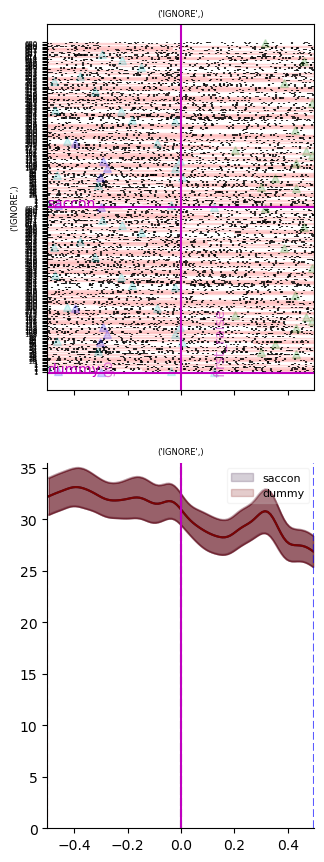

In [370]:
# Rasters and smoothed FR, split by event
chan = 5
SP.plotgood_rasters_smfr_each_level_combined(chan, var="event")

Updating this column of self.DfScalar with Dataset beh:
epoch


(<Figure size 344.52x1044 with 2 Axes>,
 array([<Axes: title={'center': "('230616',)"}>], dtype=object))

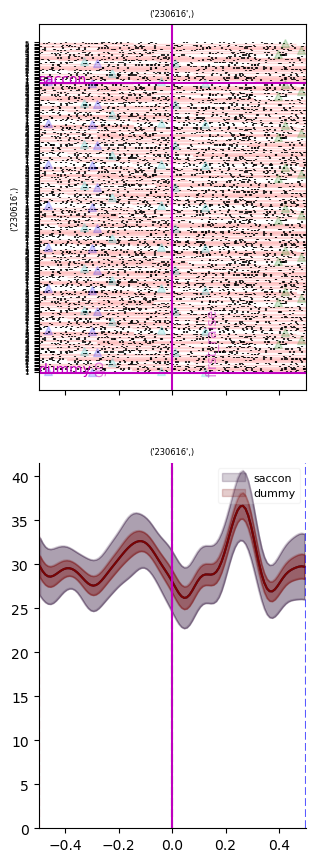

In [281]:
# you can further split data based on conjucntions of another set of variables.

# For example, let's make that same plot, but split subplots by epoch.
SP.datasetbeh_append_column("epoch", sn.Datasetbeh) # assign epoch to SP
SP.plotgood_rasters_smfr_each_level_combined(chan, var="event", vars_others=["epoch"]) # plot


(<Figure size 640x480 with 1 Axes>, <Axes: >)

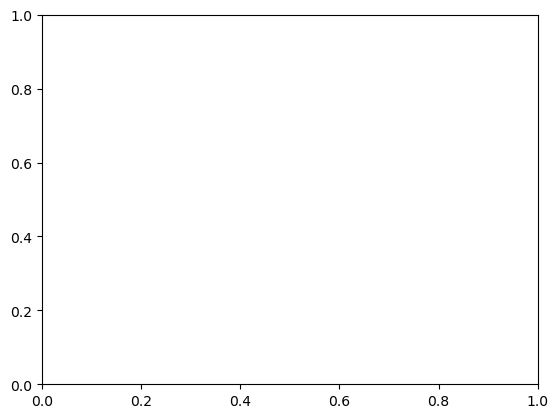

In [282]:
# We can plot the same data, but flipping which variable
SP.plotgood_rasters_smfr_each_level_combined(chan, var="epoch", vars_others=["event"]) # plot


Updating this column of self.DfScalar with Dataset beh:
epoch
Updating this column of self.DfScalar with Dataset beh:
block


(<Figure size 344.52x1044 with 2 Axes>,
 array([<Axes: title={'center': "('230616', 4)"}>], dtype=object))

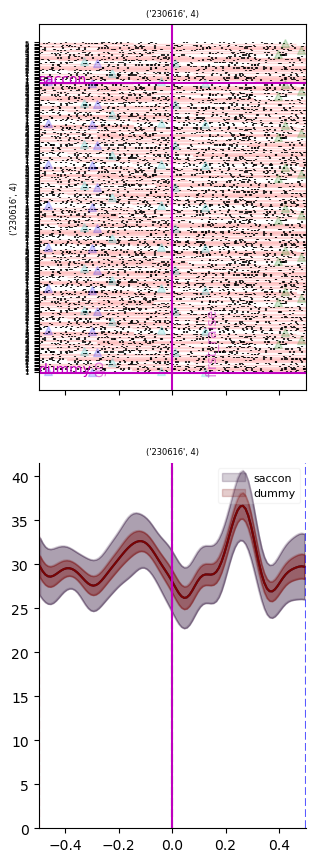

In [283]:
# You can even use conjucjtions of mltiple variables for splitting suybplots
SP.datasetbeh_append_column("epoch", sn.Datasetbeh) # assign epoch to SP
SP.datasetbeh_append_column("block", sn.Datasetbeh) # assign epoch to SP

SP.plotgood_rasters_smfr_each_level_combined(chan, var="event", vars_others=["epoch", "block"]) # plot

# Now each subplot is a specific conjucntion of the variables epoch and block.

In [ ]:
# Plot rasters for each site

In [377]:
from pythonlib.tools.plottools import savefig
sdir_rasters = "/tmp"
event="saccon"
for site in SP.Sites:
    path = f"{sdir_rasters}/{sn.sitegetter_summarytext(site)}.png"
    fig, axes = SP.plotgood_rasters_smfr_each_level_combined(site, "event", None)
    savefig(fig, path)
    plt.close("all")


### Modulation of activity by some variable of interest

In [250]:
# Run this. You need to first reextract SP, but NOT in DEBUG mode. Or else there is not enough
# data to compute modulation.

SP.modulationgood_compute_wrapper("epoch")

Running grouping_print_n_samples...
DOing these! ...
list_events ['00_saccon']
list_pre_dur [-0.5]
list_post_dur [0.5]
GOOD!, enough data, max n per grouping conjunction (nmin, nmax)  29 29
 
Updated ParamsGlobals for event 00_saccon to:
Updated self.ParamsGlobals:
n_min_trials_per_level  =  5
lenient_allow_data_if_has_n_levels  =  2
PRE_DUR_CALC  =  -0.5
POST_DUR_CALC  =  0.5
list_events  =  ['00_saccon']
list_pre_dur  =  [-0.5]
list_post_dur  =  [0.5]
DOING THIS EVENT:  00_saccon_-500_to_500
SKIPPING  00_saccon 5
SKIPPING  00_saccon 37
SKIPPING  00_saccon 66
SKIPPING  00_saccon 97
SKIPPING  00_saccon 129
SKIPPING  00_saccon 168
SKIPPING  00_saccon 193
SKIPPING  00_saccon 225
SKIPPING  00_saccon 257
SKIPPING  00_saccon 289
SKIPPING  00_saccon 324
SKIPPING  00_saccon 355
SKIPPING  00_saccon 385
SKIPPING  00_saccon 417
SKIPPING  00_saccon 449
SKIPPING  00_saccon 481
SKIPPING, extracted DF_FR_LEVELS is empty. Probably you have not enough data for this conjunctions, try setting DEBUG_CONJ

NotEnoughDataException: 